In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.backends.cudnn
torch.backends.cudnn.benchmark = True

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
batch_size = 512
hidden_dim = 512
learning_rate = 0.05
num_epochs = 20
reg = 0.0001

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
])


train_val_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_ratio = 0.9
validation_ratio = 0.1
dataset_size = len(train_val_set)
train_size = int(train_ratio * dataset_size)
validation_size = dataset_size - train_size

train_set, val_set = torch.utils.data.random_split(train_val_set, [train_size, validation_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=10, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=10, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=10, pin_memory=True)

In [4]:
class TwoLayerNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = TwoLayerNet(3 * 32 * 32, hidden_dim, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def l2_regularization(model):
    l2_norm = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            l2_norm += torch.norm(param, 2).to(device)**2
    return l2_norm

In [5]:
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss += reg * l2_regularization(model)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = 100.0 * correct_train / total_train
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)

    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss += reg * l2_regularization(model)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100.0 * correct_val / total_val
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

Epoch [1/20], Train Loss: 1.7947, Train Acc: 37.73%, Val Loss: 1.6545, Val Acc: 43.58%
Epoch [2/20], Train Loss: 1.5964, Train Acc: 45.07%, Val Loss: 1.5664, Val Acc: 46.86%
Epoch [3/20], Train Loss: 1.5133, Train Acc: 48.22%, Val Loss: 1.5282, Val Acc: 47.72%
Epoch [4/20], Train Loss: 1.4562, Train Acc: 50.23%, Val Loss: 1.4975, Val Acc: 48.62%
Epoch [5/20], Train Loss: 1.4052, Train Acc: 52.14%, Val Loss: 1.4748, Val Acc: 49.40%
Epoch [6/20], Train Loss: 1.3622, Train Acc: 54.00%, Val Loss: 1.4479, Val Acc: 50.10%
Epoch [7/20], Train Loss: 1.3311, Train Acc: 54.79%, Val Loss: 1.4523, Val Acc: 50.20%
Epoch [8/20], Train Loss: 1.2876, Train Acc: 56.57%, Val Loss: 1.4437, Val Acc: 50.56%
Epoch [9/20], Train Loss: 1.2709, Train Acc: 57.01%, Val Loss: 1.4872, Val Acc: 49.08%
Epoch [10/20], Train Loss: 1.2425, Train Acc: 58.32%, Val Loss: 1.4503, Val Acc: 50.62%
Epoch [11/20], Train Loss: 1.2178, Train Acc: 58.87%, Val Loss: 1.5027, Val Acc: 48.84%
Epoch [12/20], Train Loss: 1.2026, Train 

In [6]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 52.22%


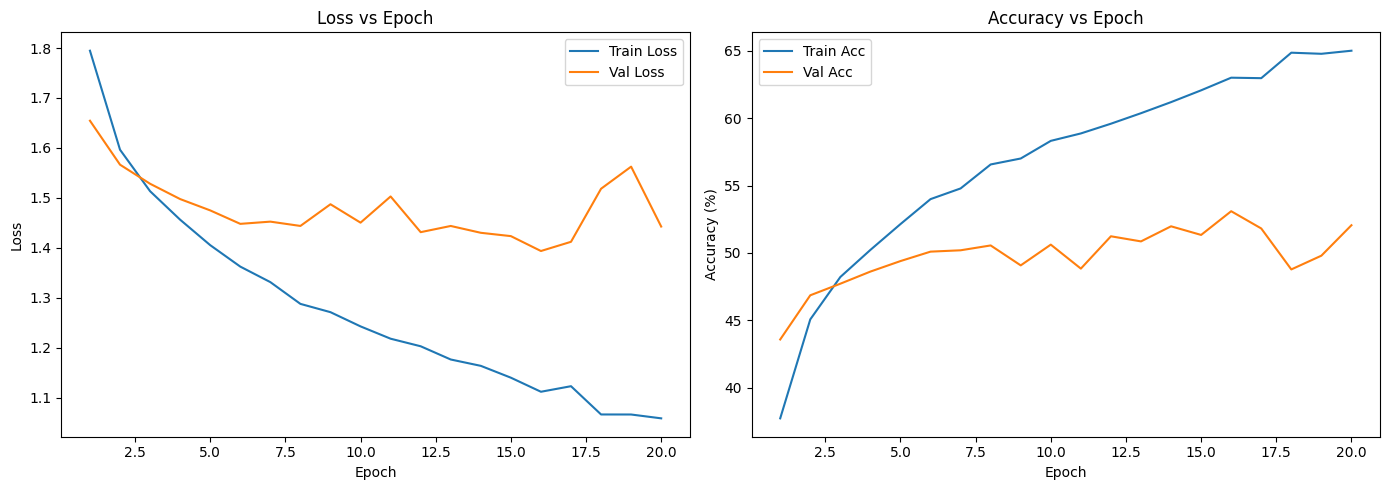

In [7]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list, label='Train Acc')
plt.plot(epochs, val_acc_list, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epoch")
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
num_epochs_CNN = 20
batch_size_CNN = 512
learning_rate_CNN = 5e-3
reg_CNN = 1e-4

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
])

train_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_set, val_set = torch.utils.data.random_split(train_val_dataset, [train_size, validation_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_CNN, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size_CNN, shuffle=False, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_CNN, shuffle=False, num_workers=4, pin_memory=True)


In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64 * 8 * 8, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

model_CNN = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNN.parameters(), lr=learning_rate_CNN, weight_decay=reg_CNN)


In [10]:
train_loss_list_CNN = []
val_loss_list_CNN = []
train_acc_list_CNN = []
val_acc_list_CNN = []

for epoch in range(num_epochs_CNN):
    model_CNN.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model_CNN(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss_list_CNN.append(total_train_loss / len(train_loader))
    train_acc_list_CNN.append(100 * correct_train / total_train)

    model_CNN.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model_CNN(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss_list_CNN.append(total_val_loss / len(val_loader))
    val_acc_list_CNN.append(100 * correct_val / total_val)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss_list_CNN[-1]:.4f}, Train Acc: {train_acc_list_CNN[-1]:.2f}%, "
          f"Val Loss: {val_loss_list_CNN[-1]:.4f}, Val Acc: {val_acc_list_CNN[-1]:.2f}%")

Epoch [1/20], Train Loss: 3.6349, Train Acc: 25.93%, Val Loss: 1.7862, Val Acc: 35.84%
Epoch [2/20], Train Loss: 1.7612, Train Acc: 36.26%, Val Loss: 1.6408, Val Acc: 39.74%
Epoch [3/20], Train Loss: 1.6333, Train Acc: 40.40%, Val Loss: 1.5183, Val Acc: 44.32%
Epoch [4/20], Train Loss: 1.4801, Train Acc: 46.75%, Val Loss: 1.3724, Val Acc: 50.70%
Epoch [5/20], Train Loss: 1.3855, Train Acc: 50.25%, Val Loss: 1.2762, Val Acc: 54.94%
Epoch [6/20], Train Loss: 1.3158, Train Acc: 52.82%, Val Loss: 1.2495, Val Acc: 56.06%
Epoch [7/20], Train Loss: 1.2567, Train Acc: 54.91%, Val Loss: 1.1907, Val Acc: 58.88%
Epoch [8/20], Train Loss: 1.1950, Train Acc: 57.46%, Val Loss: 1.1227, Val Acc: 61.44%
Epoch [9/20], Train Loss: 1.1515, Train Acc: 59.20%, Val Loss: 1.0843, Val Acc: 62.82%
Epoch [10/20], Train Loss: 1.1151, Train Acc: 60.38%, Val Loss: 1.0696, Val Acc: 63.18%
Epoch [11/20], Train Loss: 1.0859, Train Acc: 61.82%, Val Loss: 1.0369, Val Acc: 64.40%
Epoch [12/20], Train Loss: 1.0602, Train 

In [14]:
model_CNN.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_CNN(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 71.61%


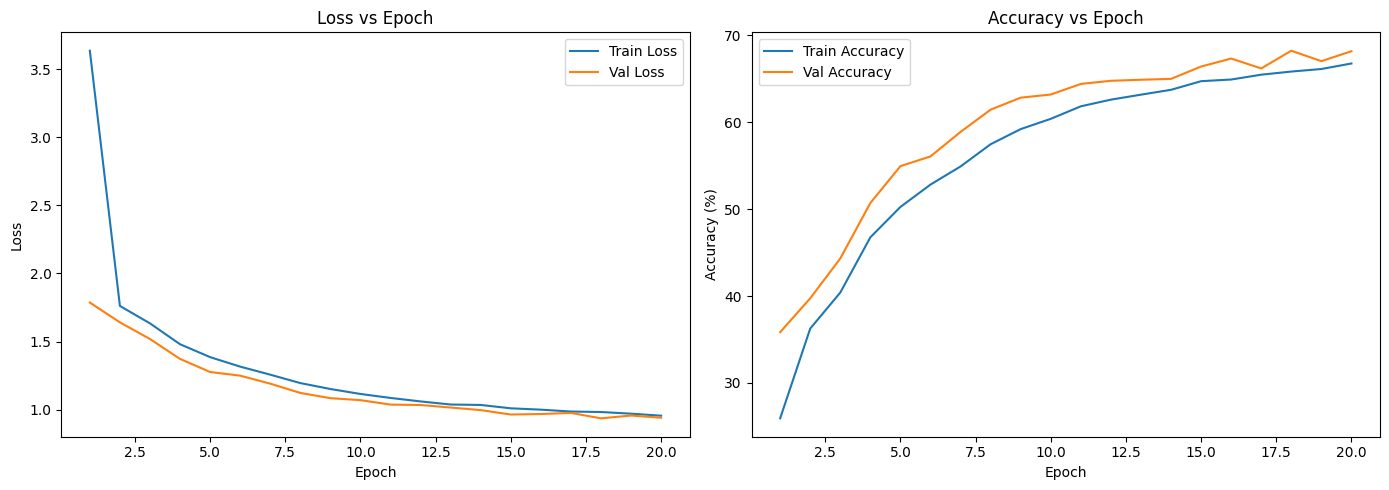

In [11]:
num_epochs_CNN = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(num_epochs_CNN, train_loss_list_CNN, label='Train Loss')
plt.plot(num_epochs_CNN, val_loss_list_CNN, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(num_epochs_CNN, train_acc_list_CNN, label='Train Accuracy')
plt.plot(num_epochs_CNN, val_acc_list_CNN, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()